In [1]:
import sys
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize, StandardScaler

import shap

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.insert(0, "../../ngboost")

In [4]:
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal, LogNormal #, SHASH

In [5]:
X, Y = load_boston(True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Pass return_X_y=True as keyword args. From version 0.25 passing these as positional arguments will result in an error


In [6]:
#ii = Y_train != 50.0
#Y_train = Y_train[ii]
#X_train = X_train[ii]

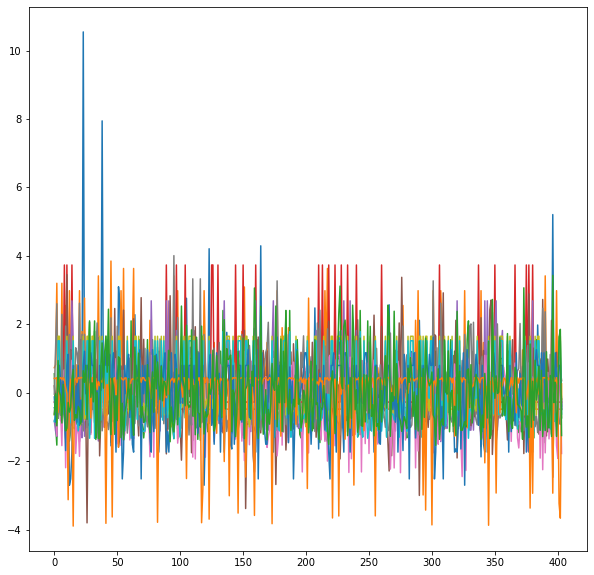

In [7]:
#xx = normalize(X_train, axis=0)
xx = StandardScaler().fit_transform(X_train)

plt.figure(figsize=(10,10))
plt.plot(xx)
plt.show()

(array([ 3.,  7.,  7., 12.,  7., 26., 20., 20., 26., 45., 37., 43., 36.,
        17.,  7., 13., 10., 11., 11.,  5.,  8.,  4.,  1.,  1.,  3.,  4.,
         2.,  2.,  1., 15.]),
 array([ 5. ,  6.5,  8. ,  9.5, 11. , 12.5, 14. , 15.5, 17. , 18.5, 20. ,
        21.5, 23. , 24.5, 26. , 27.5, 29. , 30.5, 32. , 33.5, 35. , 36.5,
        38. , 39.5, 41. , 42.5, 44. , 45.5, 47. , 48.5, 50. ]),
 <BarContainer object of 30 artists>)

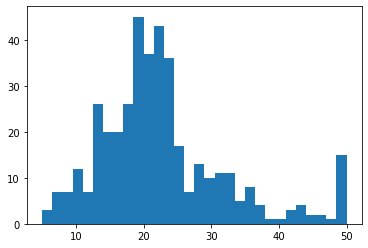

In [8]:
plt.hist(Y_train, bins=30)

## Normal

In [9]:
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal, LogNormal, SHASH

ngb = NGBRegressor(Dist=Normal, n_estimators=1000)
ngb.fit(X_train, Y_train, X_val=X_test, Y_val=Y_test)
preds = ngb.staged_predict(X_test)
print(ngb.best_val_loss_itr)
best_preds = ngb.predict(X_test, max_iter=ngb.best_val_loss_itr)

[iter 0] loss=3.6589 val_loss=3.5389 scale=1.0000 norm=6.9009
[iter 100] loss=2.7504 val_loss=2.7757 scale=2.0000 norm=5.1641
[iter 200] loss=2.1878 val_loss=2.4662 scale=2.0000 norm=3.4684
[iter 300] loss=1.9138 val_loss=2.5888 scale=2.0000 norm=2.9829
[iter 400] loss=1.7920 val_loss=2.7877 scale=1.0000 norm=1.3937
[iter 500] loss=1.6858 val_loss=3.0872 scale=1.0000 norm=1.3101
[iter 600] loss=1.6128 val_loss=3.3190 scale=1.0000 norm=1.2489
[iter 700] loss=1.5403 val_loss=3.5480 scale=1.0000 norm=1.1854
[iter 800] loss=1.4704 val_loss=3.8753 scale=1.0000 norm=1.1296
[iter 900] loss=1.4156 val_loss=4.2231 scale=1.0000 norm=1.0910
208


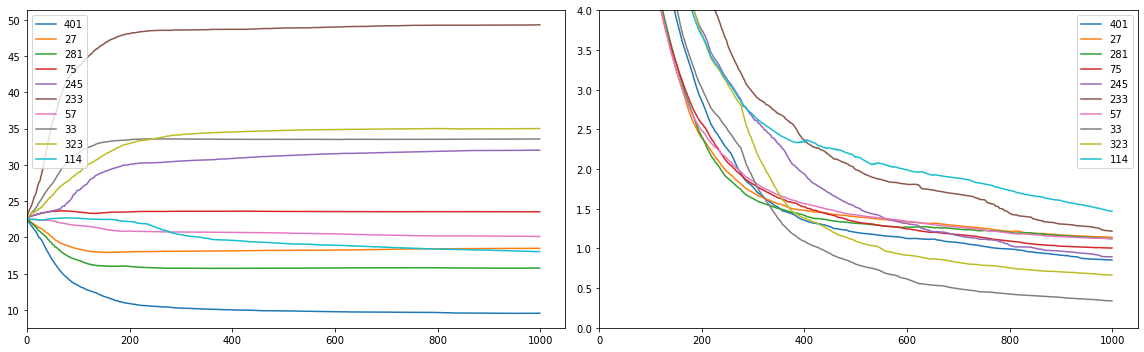

In [10]:
pred_distn = ngb.staged_pred_dist(X_train)

# Plot evolution of parameters for select test points
npars = 10
ii = np.random.choice(len(X_train), npars)
par_evol = np.array([(p[ii].params['loc'], p[ii].params['scale']) for p in pred_distn])
par_evol.shape

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,5*1))
axs = axs.flatten()
for i in range(npars):
    axs[0].plot(par_evol[:, 0, i], label=ii[i])
    axs[1].plot(par_evol[:, 1, i], label=ii[i])
    axs[0].set_xlim(0,)
    axs[1].set_xlim(0,)
    axs[1].set_ylim(0, 4)
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

In [11]:
Y_preds = ngb.predict(X_train)
Y_dists = ngb.pred_dist(X_train)

# test Mean Squared Error
test_MSE = mean_squared_error(y_pred=Y_preds, y_true=Y_train)
print('Train MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(Y_train).mean()
print('Train NLL', test_NLL)


Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

# test Mean Squared Error
test_MSE = mean_squared_error(y_pred=Y_preds, y_true=Y_test)
print('Test MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(Y_test).mean()
print('Test NLL', test_NLL)

Y_dists[0:5].params

Train MSE 1.3950236515332812
Train NLL 1.3669401207238776
Test MSE 6.866316143833386
Test NLL 4.520167682039601


{'loc': array([13.06501778, 16.37064968, 19.39009849, 18.54835247, 18.35376373]),
 'scale': array([1.17507794, 1.24980503, 1.07709574, 1.44966425, 1.37806108])}

## SHASH

In [12]:
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal, LogNormal, SHASH

np.seterr(all="ignore", under="ignore")

ngbs = NGBRegressor(Dist=SHASH, n_estimators=1000, natural_gradient=True)
ngbs.fit(X_train, Y_train, X_val=X_test, Y_val=Y_test)
preds = ngbs.staged_predict(X_test)
print(ngbs.best_val_loss_itr)
best_preds = ngbs.predict(X_test, max_iter=ngbs.best_val_loss_itr)

Fitted normal:  22.59529702970297 9.392964117453731 2.2399609108681426
result:       fun: 3.5512736747573257
 hess_inv: array([[117.05399053, -13.84053461,  -8.67350001,  -8.54802842],
       [-13.84053461,   9.3361427 ,   1.71229793,   4.67652093],
       [ -8.67350001,   1.71229793,   1.12603764,   1.02040327],
       [ -8.54802842,   4.67652093,   1.02040327,   2.59766561]])
      jac: array([ 4.93515228e-08, -1.81530322e-07,  1.41851003e-06,  4.36540538e-07])
  message: 'Optimization terminated successfully.'
     nfev: 22
      nit: 18
     njev: 22
   status: 0
  success: True
        x: array([19.34654313,  1.4084746 ,  0.26925842, -0.41991226])
fitted 19.346543126404477 4.089712184169254 0.2692584189224696 0.6571044711315933
[iter 0] loss=3.5513 val_loss=3.4613 scale=0.2500 norm=2.6387
[iter 100] loss=3.0604 val_loss=3.0539 scale=0.0625 norm=1.2378
[iter 200] loss=3.0155 val_loss=3.0121 scale=0.0078 norm=0.2593
[iter 300] loss=3.0064 val_loss=3.0037 scale=0.0078 norm=0.2856
[it

In [13]:
x = np.empty_like(Y_train)

In [14]:
x[:] = np.inf

In [15]:
np.any(x == np.nan)

False

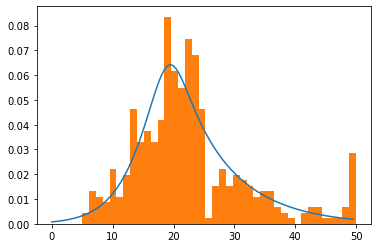

In [16]:
# Test marginal probability fit
x = np.arange(0, 50, 0.5)
y=SHASH.dSHASHo(np.array([19.45042339,  1.42281581,  0.25263455, -0.40219733]), x)
plt.plot(x, y)
_ = plt.hist(Y_train, bins=40, density=True)

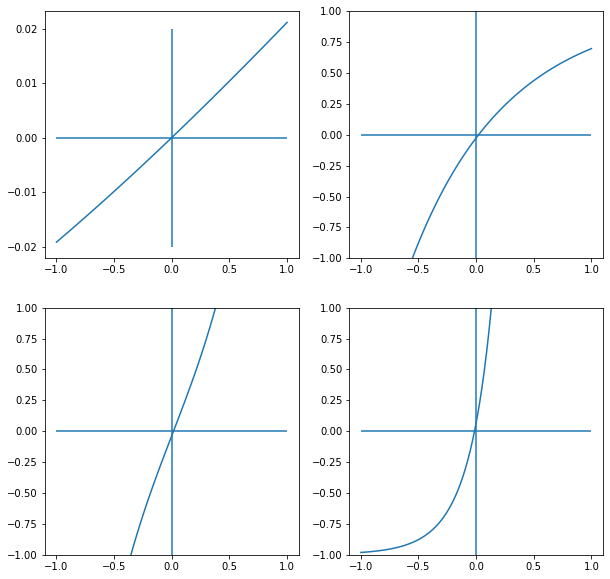

In [17]:
# Check if gradients of NLL go through a minimum at the minimum of NLL

pars = np.array([19.45042339,  1.42281581,  0.25263455, -0.40219733])
y = []
rng = np.linspace(-1, 1, 100)
for i in range(len(pars)):
    y.append([])
    for r in rng:
        pm = np.copy(pars)
        pm[i] += r
        y[-1].append(SHASH.grad_nll(pm, Y_train)[i])

    
y = np.array(y).T
#y=SHASH.grad_nll(np.array([19.33028413, 1.44696399, 0.26685672, -0.39977293]), ar)
#print(y)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].plot(rng, y[:, i])
    axs[i].hlines(0, -1, 1)
    if i > 0:
        axs[i].set_ylim(-1, 1)
        axs[i].vlines(0, -1, 1)
    else:
        axs[i].vlines(0, -0.02, 0.02)

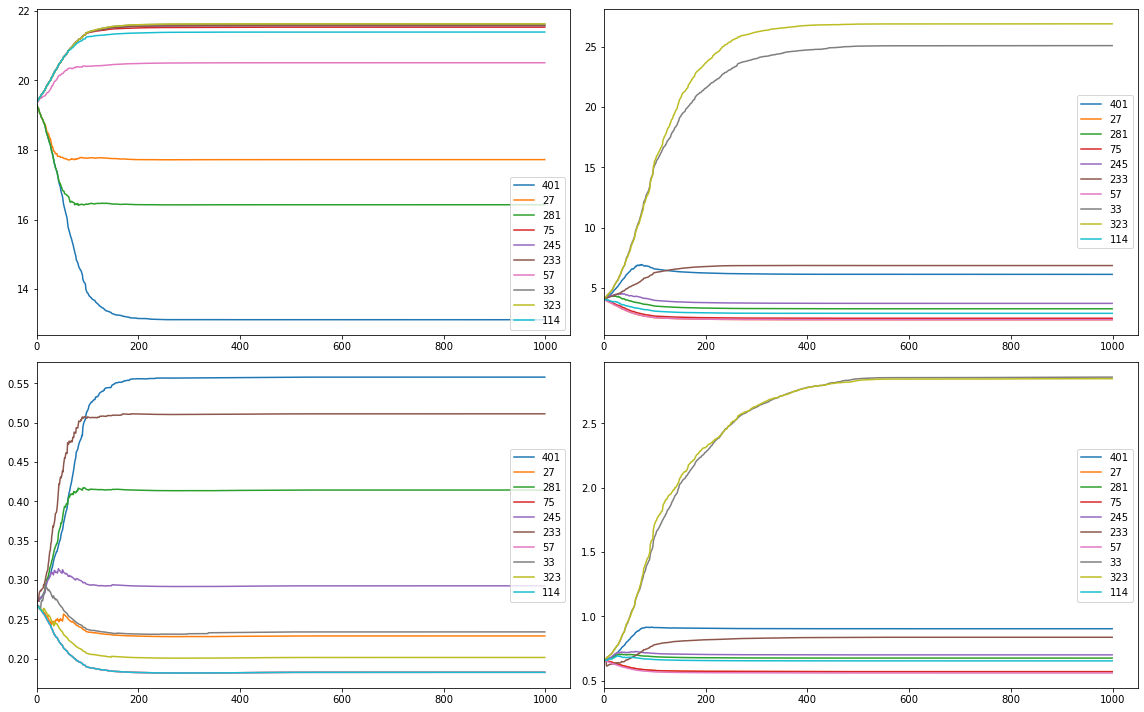

In [18]:
pred_dists = ngbs.staged_pred_dist(X_train)
# Plot evolution of parameters for select test points
npars = 10
#ii = np.random.choice(len(X_train), npars)
par_evol = np.array([(p[ii].params['loc'], p[ii].params['scale'], p[ii].params['nu'], p[ii].params['tau']) for p in pred_dists])
par_evol.shape

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,5*2))
axs = axs.flatten()
for i in range(npars):
    for ip in range(4):
        axs[ip].plot(par_evol[:, ip, i], label=ii[i])
    #axs[1].plot(par_evol[:, 1, i], label=ii[i])
        axs[ip].set_xlim(0,)
    #axs[1].set_xlim(200,)
    #axs[1].set_ylim(0, 4)
for ip in range(4):
    axs[ip].legend()

plt.tight_layout()
plt.show()

In [19]:
Y_preds = ngbs.predict(X_train)
Y_dists = ngbs.pred_dist(X_train)

# test Mean Squared Error
test_MSE = mean_squared_error(y_pred=Y_preds, y_true=Y_train)
print('Train MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(Y_train).mean()
print('Train NLL', test_NLL)

Y_preds = ngbs.predict(X_test)
Y_dists = ngbs.pred_dist(X_test)

# test Mean Squared Error
test_MSE = mean_squared_error(y_pred=Y_preds, y_true=Y_test)
print('Test MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(Y_test).mean()
print('Test NLL', test_NLL)

Y_dists[0:5].params

Train MSE 54.480842988734636
Train NLL 3.0031740297238656
Test MSE 41.59899535429013
Test NLL 2.994277972395786


{'loc': array([17.38512774, 15.72912983, 18.19975328, 17.82031463, 15.50985241]),
 'scale': array([2.76249152, 2.78458425, 2.40172605, 2.95597213, 7.69841164]),
 'nu': array([0.3462248 , 0.46242001, 0.29063781, 0.39462967, 0.544105  ]),
 'tau': array([0.63819061, 0.64861737, 0.58335694, 0.66108137, 1.03643788])}

In [20]:
pred_distn = ngbs.staged_pred_dist(X_train)

len(pred_distn)

1000

In [21]:
Y_preds = ngbs.predict(X_train)
#Y_dists = ngbs.pred_dist(X_train)
Y_dists = pred_distn[0]

# test Mean Squared Error
test_MSE = mean_squared_error(y_pred=Y_preds, y_true=Y_train)
print('Train MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(Y_train).mean()
print('Train NLL', test_NLL)

Train MSE 54.480842988734636
Train NLL 3.545232935156426


(2.0, 3.6)

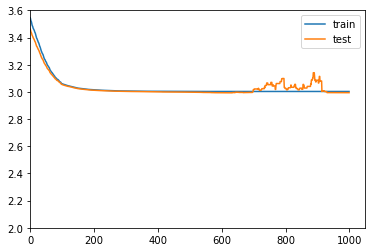

In [22]:
pred_distn = ngbs.staged_pred_dist(X_train)
nll = [-d.logpdf(Y_train).mean() for d in pred_distn]
plt.plot(nll, label='train')

pred_distn = ngbs.staged_pred_dist(X_test)
nll = [-d.logpdf(Y_test).mean() for d in pred_distn]
plt.plot(nll, label='test')
plt.legend()
plt.xlim(0,)
plt.ylim(2., 3.6)

Text(0.5, 1.0, 'scale param')

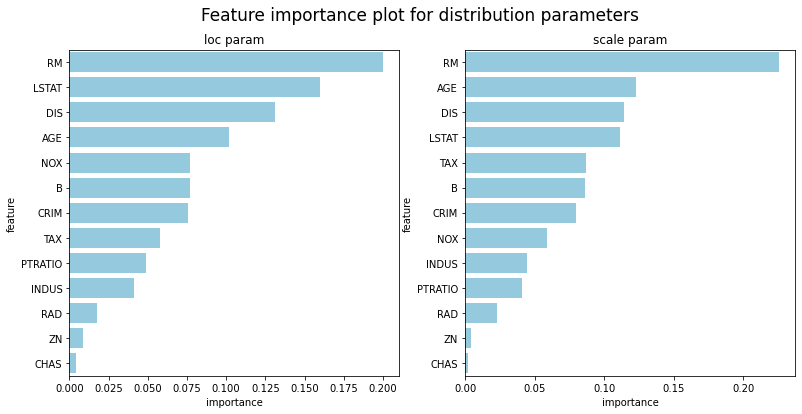

In [23]:
feature_importance_loc = ngb.feature_importances_[0]

## Feature importance for scale trees
feature_importance_scale = ngb.feature_importances_[1]

df_loc = pd.DataFrame({'feature':load_boston()['feature_names'],
                       'importance':feature_importance_loc})\
    .sort_values('importance',ascending=False)
df_scale = pd.DataFrame({'feature':load_boston()['feature_names'],
                       'importance':feature_importance_scale})\
    .sort_values('importance',ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
fig.suptitle("Feature importance plot for distribution parameters", fontsize=17)
sns.barplot(x='importance',y='feature',ax=ax1,data=df_loc, color="skyblue").set_title('loc param')
sns.barplot(x='importance',y='feature',ax=ax2,data=df_scale, color="skyblue").set_title('scale param')

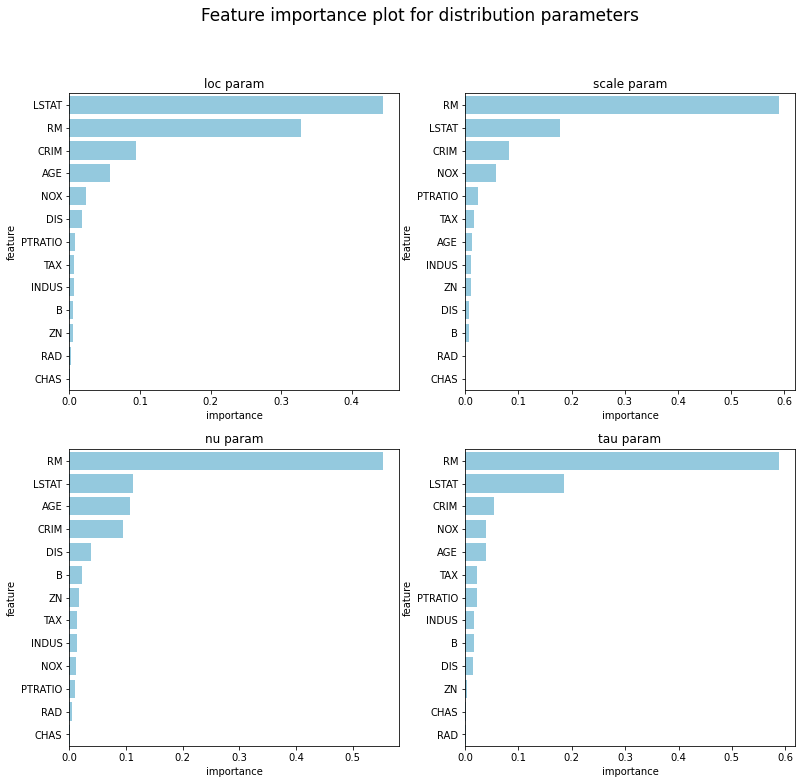

In [24]:
feature_importance_loc = ngbs.feature_importances_[0]
feature_importance_scale = ngbs.feature_importances_[1]
feature_importance_nu = ngbs.feature_importances_[2]
feature_importance_tau = ngbs.feature_importances_[3]

df_loc = pd.DataFrame({'feature':load_boston()['feature_names'],
                       'importance':feature_importance_loc})\
    .sort_values('importance',ascending=False)
df_scale = pd.DataFrame({'feature':load_boston()['feature_names'],
                       'importance':feature_importance_scale})\
    .sort_values('importance',ascending=False)
df_nu = pd.DataFrame({'feature':load_boston()['feature_names'],
                       'importance':feature_importance_nu})\
    .sort_values('importance',ascending=False)
df_tau = pd.DataFrame({'feature':load_boston()['feature_names'],
                       'importance':feature_importance_tau})\
    .sort_values('importance',ascending=False)

fig, axs = plt.subplots(2, 2, figsize=(13,12))
ax1, ax2, ax3, ax4 = axs.ravel()
fig.suptitle("Feature importance plot for distribution parameters", fontsize=17)
sns.barplot(x='importance',y='feature',ax=ax1,data=df_loc, color="skyblue").set_title('loc param')
sns.barplot(x='importance',y='feature',ax=ax2,data=df_scale, color="skyblue").set_title('scale param')
sns.barplot(x='importance',y='feature',ax=ax3,data=df_nu, color="skyblue").set_title('nu param')
sns.barplot(x='importance',y='feature',ax=ax4,data=df_tau, color="skyblue").set_title('tau param')
plt.show()

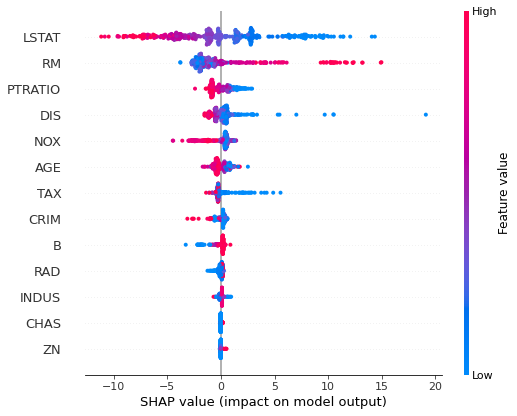

In [25]:
shap.initjs()

## SHAP plot for loc trees
explainer = shap.TreeExplainer(ngb, model_output=0) # use model_output = 1 for scale trees
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=load_boston()['feature_names'])

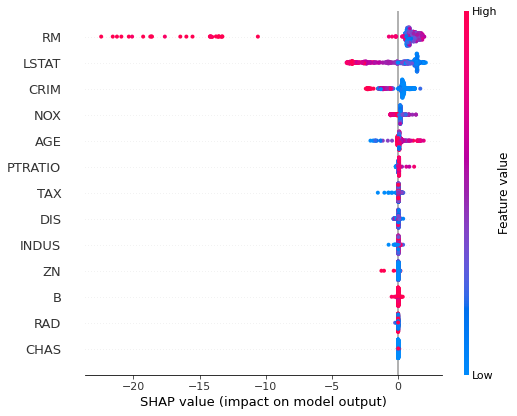

In [26]:
shap.initjs()

## SHAP plot for loc trees
explainer = shap.TreeExplainer(ngbs, model_output=0) # use model_output = 1 for scale trees
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=load_boston()['feature_names'])

In [27]:
b1 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=2)
b2 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=4)
b3 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=6)

param_grid = {
    'minibatch_frac': [1.0, 0.5],
    'Base': [b1, b2, b3]
}

ngb = NGBRegressor(Dist=Normal, verbose=False)

grid_search = GridSearchCV(ngb, param_grid=param_grid, cv=4, verbose=1, n_jobs=12)
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  24 out of  24 | elapsed:   13.6s finished


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'minibatch_frac': 1.0}


In [128]:
%%timeit
K = 10
a = [int(np.floor(np.random.rand()*K)) for _ in range(100000)]

99.1 ms ± 2.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


(array([ 9735.,  9808., 10076., 10064., 10105.,  9937., 10086.,  9971.,
        10226.,  9992.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

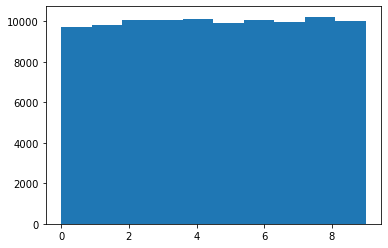

In [123]:
plt.hist(a, bins=10)

In [129]:
%%timeit
b = np.random.randint(K, size=100000)

1.03 ms ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


(array([16., 12., 11.,  7., 12.,  7.,  9.,  9.,  6., 11.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

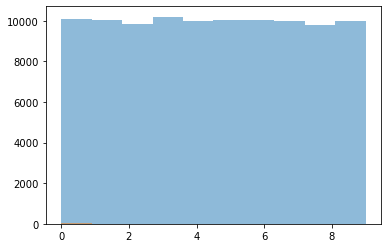

In [98]:
plt.hist(a, bins=10, alpha=0.5)
plt.hist(b, bins=10, alpha=0.5)

In [99]:
np.random.randint(5)

3

In [131]:
import numpy as np

def alias_setup(probs):
    K       = len(probs)
    q       = np.zeros(K)
    J       = np.zeros(K, dtype=np.int)

    # Sort the data into the outcomes with probabilities
    # that are larger and smaller than 1/K.
    smaller = []
    larger  = []
    for kk, prob in enumerate(probs):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    # Loop though and create little binary mixtures that
    # appropriately allocate the larger outcomes over the
    # overall uniform mixture.
    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] - (1.0 - q[small])

        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def alias_draw(J, q):
    K  = len(J)

    # Draw from the overall uniform mixture.
    kk = int(np.floor(np.random.rand()*K))  # Faste5 for generating single random numbers
    #kk = np.random.randint(K)   # Faster for generating large arrays of random numbers

    # Draw from the binary mixture, either keeping the
    # small one, or choosing the associated larger one.
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


In [132]:
%%timeit
K = 5
N = 10000

# Get a random probability vector.
probs = np.random.dirichlet(np.ones(K), 1).ravel()

# Construct the table.
J, q = alias_setup(probs)

# Generate variates.
X = np.zeros(N)
for nn in range(N):
    X[nn] = alias_draw(J, q)

16.6 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<BarContainer object of 5 artists>

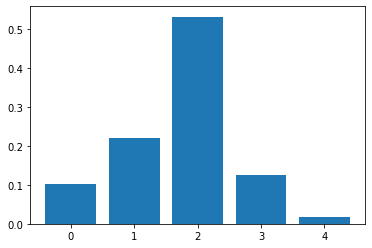

In [108]:
plt.bar(range(K), probs)

<BarContainer object of 5 artists>

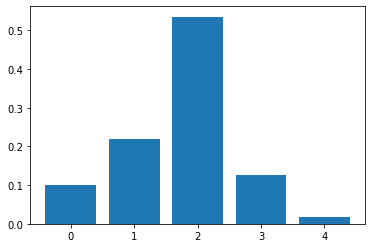

In [113]:
counts = np.array([np.count_nonzero(X == i) for i in range(K)])

plt.bar(range(K), counts/np.sum(counts))

In [110]:
np.count(X)

AttributeError: module 'numpy' has no attribute 'count'

In [54]:
from scipy.stats import dirichlet
test_sample = np.array([1.865, 3.053, 1.401, 0.569, 4.132])
dirichlet_samples = dirichlet([1] * len(test_sample)).rvs(100000)

In [55]:
dirichlet_samples

array([[0.05631266, 0.19698943, 0.08939093, 0.3014631 , 0.35584388],
       [0.35548522, 0.31144552, 0.11608905, 0.09002031, 0.12695991],
       [0.01235499, 0.51740201, 0.06991382, 0.05421607, 0.3461131 ],
       ...,
       [0.43832157, 0.09333147, 0.32596124, 0.13058225, 0.01180347],
       [0.09420414, 0.41684252, 0.01790239, 0.25480053, 0.21625041],
       [0.0059691 , 0.83321632, 0.03172079, 0.00953411, 0.11955968]])

In [56]:
bayes_boots_samples = (test_sample * dirichlet_samples).sum(axis=1)

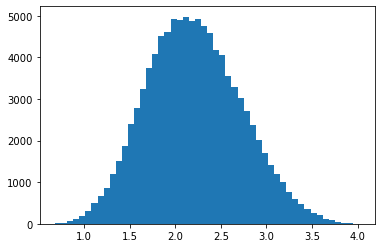

In [57]:
_ = plt.hist(bayes_boots_samples, bins=50)